In [104]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.applications import ResNet50, VGG19, VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.combine import SMOTEENN, SMOTETomek

In [105]:
# Loading the data

X_labeled = np.load("Xtrain1.npy")
X_unlabeled = np.load("Xtrain1_extra.npy")
Y_train_labeled = np.load("Ytrain1.npy")
X_test = np.load("Xtest1.npy")

(2783, 2304)
(904, 2304)


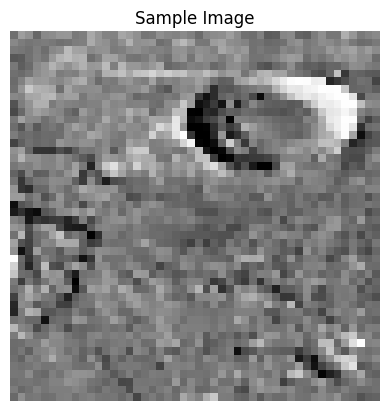

In [106]:
print(X_labeled.shape)
print(X_unlabeled.shape)

#Normalization

X_labeled = X_labeled/255
X_unlabeled = X_unlabeled/255
X_test = X_test/255

resized = np.resize(X_labeled[1], [48,48])
plt.imshow(resized, cmap='gray')
plt.title("Sample Image")
plt.axis('off')
plt.show()

In [107]:
# Data Imbalance

crater_images = sum(Y_train_labeled)
no_crater_images = len(Y_train_labeled) - crater_images
ratio_no_crater_crater = no_crater_images/crater_images
print("Number of crater images: ", crater_images)
print("Number of no crater images: ", no_crater_images)
print("Ratio no crater/crater: ", ratio_no_crater_crater)

#Class Weights

class_weights_first = compute_class_weight(class_weight='balanced', classes=np.unique(Y_train_labeled), y=Y_train_labeled.flatten())
class_weight_dict_first = dict(enumerate(class_weights_first))
print("Class weights: ", class_weight_dict_first)

Number of crater images:  1777
Number of no crater images:  1006
Ratio no crater/crater:  0.566122678671919
Class weights:  {0: 1.3832007952286283, 1: 0.7830613393359594}


In [108]:
# Reshaping and Data Splitting

X_train_reshaped = X_labeled.reshape(len(X_labeled), 48, 48, 1)
X_extra_train = X_unlabeled.reshape(len(X_unlabeled), 48, 48, 1)
X_test_reshaped = X_test.reshape(len(X_test), 48, 48, 1)

X_train, X_val, Y_train, Y_val = train_test_split(X_train_reshaped, Y_train_labeled, test_size=0.2, random_state=42)

Methods for Data Imbalance: Data Augmentation only on Minority Class

Data augmentation is a technique that can be used to improve the robustness and accuracy of a machine learning model by creating additional examples from the original dataset.

https://www.picsellia.com/post/improve-imbalanced-datasets-in-computer-vision


In [109]:
majority_indices = np.where(Y_train == 1)[0]
minority_indices = np.where(Y_train == 0)[0]

X_train_majority = X_train[majority_indices]
X_train_minority = X_train[minority_indices]

target_minority_samples = len(X_train_majority)
num_augmented_samples = target_minority_samples - len(X_train_minority)

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_minority_images = []
for i in range(num_augmented_samples):
    img = X_train_minority[i % len(X_train_minority)].reshape((1, 48, 48, 1))
    augmented_img = next(datagen.flow(img, batch_size=1))[0]
    augmented_minority_images.append(augmented_img)

X_train_minority_balanced = np.concatenate([X_train_minority, np.array(augmented_minority_images)])
Y_train_minority_balanced = np.zeros(len(X_train_minority_balanced))

X_train_balanced_DA = np.concatenate([X_train_majority, X_train_minority_balanced])
Y_train_balanced_DA = np.concatenate([np.ones(len(X_train_majority)), Y_train_minority_balanced])

indices = np.arange(len(Y_train_balanced_DA))
np.random.shuffle(indices)
X_train_balanced_DA, Y_train_balanced_DA = X_train_balanced_DA[indices], Y_train_balanced_DA[indices]

print("Balanced training set shape:", X_train_balanced_DA.shape)
print("Balanced class distribution:", np.bincount(Y_train_balanced_DA.astype(int)))

Balanced training set shape: (2814, 48, 48, 1)
Balanced class distribution: [1407 1407]


Methods for Data Imbalance: Random Sampling

https://medium.com/@shubhamgupta.3101994/addressing-data-imbalance-in-image-classification-techniques-and-strategies-b922fb3c5124
https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

There are two main approaches to random resampling for imbalanced classification; they are oversampling and undersampling.

 - Random Oversampling: Randomly duplicate examples in the minority class.
 - Random Undersampling: Randomly delete examples in the majority class.

Random resampling provides a naive technique for rebalancing the class distribution for an imbalanced dataset.
Random oversampling duplicates examples from the minority class in the training dataset and can result in overfitting for some models.

Random undersampling deletes examples from the majority class and can result in losing information invaluable to a model.

Random Over Sampling (ROS)

In [110]:
X_train_flattened = X_train_balanced_DA.reshape(len(X_train_balanced_DA), -1)
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_ROS, Y_train_ROS = ros.fit_resample(X_train_flattened, Y_train_balanced_DA)
X_train_ROS = X_train_ROS.reshape(-1, 48, 48, 1)
unique, counts = np.unique(Y_train_ROS, return_counts=True)
print("Balanced class distribution:", dict(zip(unique, counts)))

print(X_train_ROS.shape)
print(Y_train_ROS.shape)

Balanced class distribution: {0.0: 1407, 1.0: 1407}
(2814, 48, 48, 1)
(2814,)


Random Under Sampling (RUS)

In [ ]:
X_train_flattened = X_train.reshape(len(X_train), -1)
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_RUS, Y_train_RUS = rus.fit_resample(X_train_flattened, Y_train)
X_train_RUS = X_train_RUS.reshape(-1, 48, 48, 1)
unique, counts = np.unique(Y_train_RUS, return_counts=True)
print("Balanced class distribution:", dict(zip(unique, counts)))

SMOTE

In [ ]:
X_train_flattened = X_train.reshape(len(X_train), -1)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_SMOTE, Y_train_SMOTE = smote.fit_resample(X_train_flattened, Y_train)
X_train_SMOTE = X_train_SMOTE.reshape(-1, 48, 48, 1)
unique, counts = np.unique(Y_train_SMOTE, return_counts=True)
print("Balanced class distribution:", dict(zip(unique, counts)))

Combination of ROS and RUS

In [ ]:
X_train_flattened = X_train.reshape(len(X_train), -1)
ros = RandomOverSampler(sampling_strategy=0.95, random_state=42)
X_train_over, Y_train_over = ros.fit_resample(X_train_flattened, Y_train)

rus = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
X_train_both, Y_train_both = rus.fit_resample(X_train_over, Y_train_over)

#X_train_balanced = X_train_over.reshape(-1, 48, 48, 1) 
X_train_both = X_train_both.reshape(-1, 48, 48, 1)

unique, counts = np.unique(Y_train_over, return_counts=True)
print("Final balanced class distribution:", dict(zip(unique, counts)))

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_51 (Conv2D)              │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,073 (1.35 MB)

 Trainable params: 355,073 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
 7/88 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4196 - loss: 0.6952

/opt/homebrew/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5044 - loss: 0.6884 - val_accuracy: 0.6697 - val_loss: 0.5975
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6825 - loss: 0.6321 - val_accuracy: 0.7092 - val_loss: 0.6343
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7538 - loss: 0.5603 - val_accuracy: 0.7325 - val_loss: 0.5910
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7572 - loss: 0.5365 - val_accuracy: 0.7271 - val_loss: 0.6363
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7815 - loss: 0.5044 - val_accuracy: 0.7666 - val_loss: 0.5679
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7914 - loss: 0.4781 - val_accuracy: 0.7738 - val_loss: 0.5624
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8109 - loss: 0.4679 - val_accuracy: 0.7271 - val_loss: 0.6977
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8042 - loss: 0.4597 - val_accuracy: 0.7648 - val_l

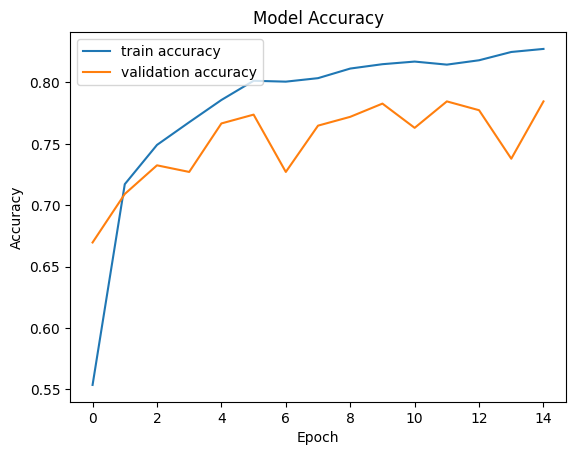

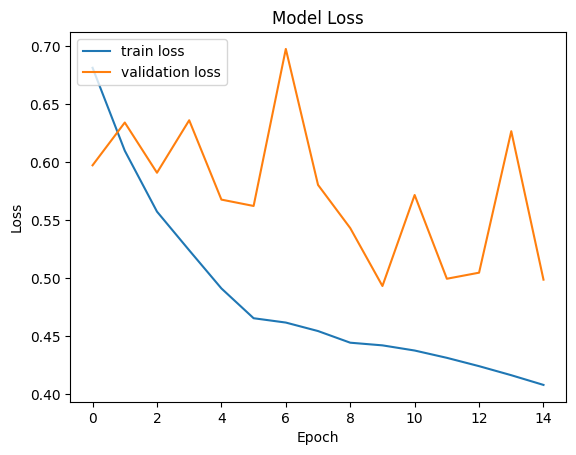

In [111]:
# Build CNN model
def create_model():
    model = Sequential()

    # Convolutional Layer 1
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Layer 2
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Layer 3
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flattening
    model.add(Flatten())

    # Fully connected layer with dropout
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer (binary classification)
    model.add(Dense(1, activation='sigmoid'))
    adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    # Compile the model
    model.compile(optimizer= adam, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create and summarize the model
model = create_model()
model.summary()

# Train the model
batch_size = 32
epochs = 100

early_stopping = EarlyStopping(
    monitor='val_loss',     # Metric to monitor
    patience=5, # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore weights from the best epoch
)

history = model.fit(
    datagen.flow(X_train_ROS, Y_train_ROS, batch_size=batch_size),
    validation_data=(X_val, Y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping]
    )
augmented_images = []
augmented_labels = []

# Define how many augmented images you want to generate
num_augmented_images = 100  # Adjust this number as needed

# Loop through batches of augmented data
for X_batch, Y_batch in datagen.flow(X_train_ROS, Y_train_ROS, batch_size=batch_size):
    augmented_images.append(X_batch)
    augmented_labels.append(Y_batch)
    
    # Break once we have enough augmented images
    if len(augmented_images) * batch_size >= num_augmented_images:
        break

# Convert lists to numpy arrays
augmented_images = np.concatenate(augmented_images)[:num_augmented_images]
augmented_labels = np.concatenate(augmented_labels)[:num_augmented_images]

# Concatenate augmented data with original data
X_train_combined = np.concatenate((X_train_ROS, augmented_images), axis=0)
Y_train_combined = np.concatenate((Y_train_ROS, augmented_labels), axis=0)

# Check the new shape of the training data
print("Shape of original data:", X_train_ROS.shape)
print("Shape of augmented data:", augmented_images.shape)
print("Shape of combined data:", X_train_combined.shape)

# Evaluate the model
val_preds = model.predict(X_val)
val_preds = np.round(val_preds)

# Classification report
print(classification_report(Y_val, val_preds))

# F1 Score
f1 = f1_score(Y_val, val_preds, average = 'macro')
print("F1 Score: ", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_val, val_preds)
print("Confusion Matrix:\n", conf_matrix)

# Plotting training history
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


Pre-Trained VGG19

Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 384ms/step - accuracy: 0.7472 - loss: 0.5014 - val_accuracy: 0.8276 - val_loss: 0.3767
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 389ms/step - accuracy: 0.8947 - loss: 0.2715 - val_accuracy: 0.8743 - val_loss: 0.2568
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 435ms/step - accuracy: 0.8980 - loss: 0.2724 - val_accuracy: 0.9120 - val_loss: 0.2185
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.9397 - loss: 0.1851 - val_accuracy: 0.9048 - val_loss: 0.2763
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 35s 375ms/step - accuracy: 0.9231 - loss: 0.2178 - val_accuracy: 0.8869 - val_loss: 0.3035
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 390ms/step - accuracy: 0.9529 - loss: 0.1353 - val_accuracy: 0.9102 - val_loss: 0.2231
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 37s 403ms/step - accuracy: 0.9568 - loss: 0.1276 - val_accuracy: 0.9120 - val_loss: 0.3230
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 49s 530ms/step - accuracy: 0.9671 - loss: 0.0928 - val_accura

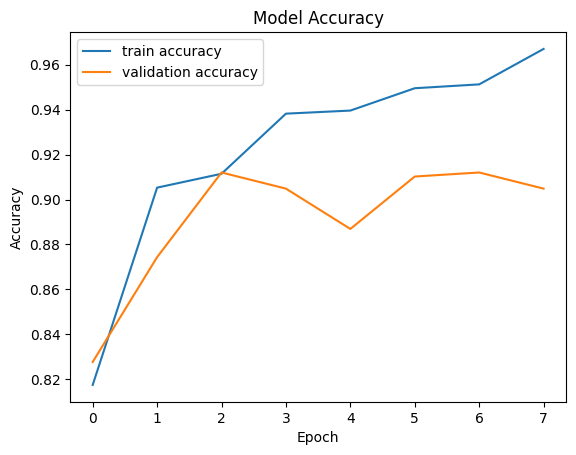

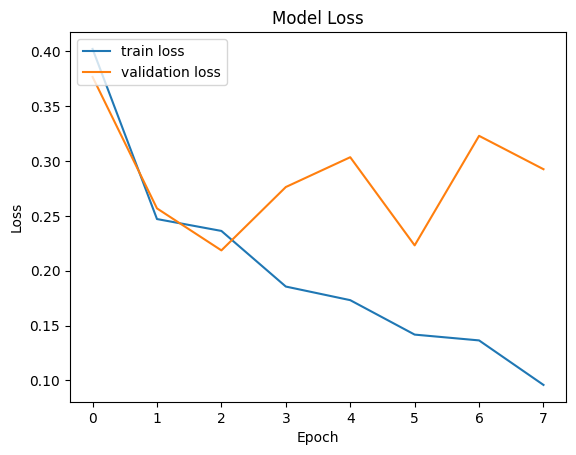

In [112]:
X_train_rgb = np.repeat(X_train_combined, 3, axis=-1)  # Converts (48, 48, 1) to (48, 48, 3)
X_val_rgb = np.repeat(X_val, 3, axis=-1)

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Freeze the initial layers of VGG19 to retain pre-trained features
for layer in base_model.layers[:-8]:  # Adjust number of layers to unfreeze more, if necessary
    layer.trainable = False

# Add custom classification layers on top
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x= Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_rgb, Y_train_combined, 
    batch_size=32,
    validation_data=(X_val_rgb, Y_val),
    epochs=30,
    callbacks = [early_stopping]
)

val_preds = model.predict(X_val_rgb)
val_preds = np.round(val_preds)

# Classification report
print(classification_report(Y_val, val_preds))

# F1 Score
f1 = f1_score(Y_val, val_preds, average='macro')
print("F1 Score: ", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_val, val_preds)
print("Confusion Matrix:\n", conf_matrix)

# Plotting training history
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

Pre-trained VGG16

Epoch 1/30


/opt/homebrew/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 347ms/step - accuracy: 0.7443 - loss: 0.5202 - val_accuracy: 0.9048 - val_loss: 0.2506
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 360ms/step - accuracy: 0.8668 - loss: 0.3412 - val_accuracy: 0.9174 - val_loss: 0.2024
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8885 - loss: 0.2783 - val_accuracy: 0.9156 - val_loss: 0.2111
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 34s 370ms/step - accuracy: 0.8985 - loss: 0.2532 - val_accuracy: 0.8887 - val_loss: 0.2634
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 34s 372ms/step - accuracy: 0.9148 - loss: 0.2242 - val_accuracy: 0.9174 - val_loss: 0.1898
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 446ms/step - accuracy: 0.9201 - loss: 0.2228 - val_accuracy: 0.8707 - val_loss: 0.2507
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 34s 372ms/step - accuracy: 0.9114 - loss: 0.2108 - val_accuracy: 0.9120 - val_loss: 0.2095
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 37s 400ms/step - accuracy: 0.9271 - loss: 0.1761 - val_accuracy: 0.930

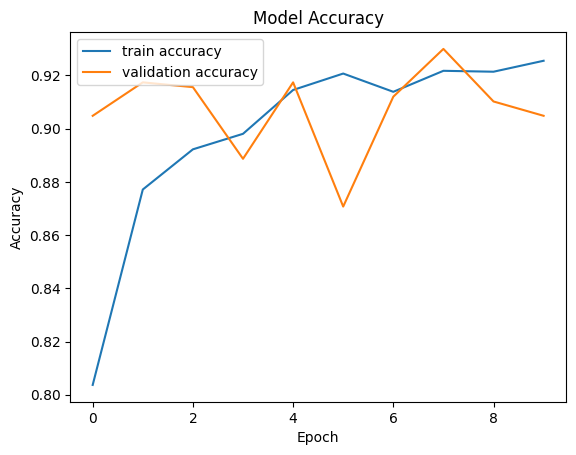

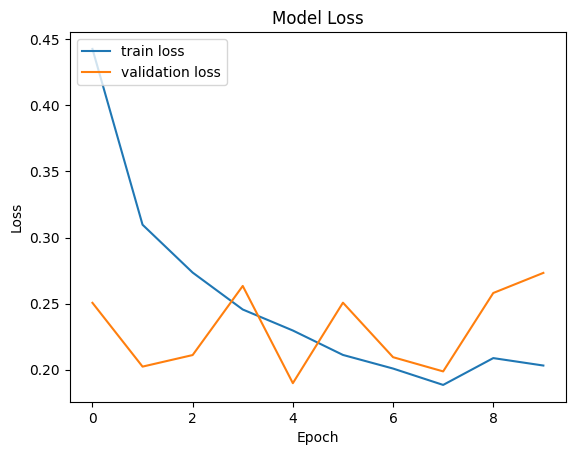

In [113]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

for layer in base_model.layers[:-8]:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    datagen.flow(X_train_rgb, Y_train_combined,batch_size=32), 
    validation_data=(X_val_rgb, Y_val),
    epochs=30,
    callbacks = [early_stopping]
)

val_preds = model.predict(X_val_rgb)
val_preds = np.round(val_preds)

# Classification report
print(classification_report(Y_val, val_preds))

# F1 Score
f1 = f1_score(Y_val, val_preds, average='macro')
print("F1 Score: ", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_val, val_preds)
print("Confusion Matrix:\n", conf_matrix)

# Plotting training history
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

Using the unlabeled data

In [ ]:
# Normalize the unlabeled data (values between 0 and 1)
X_unlabeled_norm = X_unlabeled / 255.0
X_unlabeled_norm = X_unlabeled_norm.reshape(X_unlabeled_norm.shape[0], 48, 48, 1)

# Train the CNN model on labeled data first (the code you already have)

model = create_model()
model.summary()

batch_size = 32
epochs = 30

# Train the model on the labeled dataset
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_val, y_val),
    epochs=epochs
)

# Step 1: Use the trained CNN model to generate pseudo-labels for the unlabeled data
# Get predictions for the unlabeled data
unlabeled_preds = model.predict(X_unlabeled_norm)

# Step 2: Apply a threshold to assign pseudo-labels based on prediction confidence
# For binary classification, pseudo-labels are 0 or 1 depending on confidence
pseudo_labels = np.where(unlabeled_preds > 0.9, 1, np.where(unlabeled_preds < 0.1, 0, -1))

# Only keep confident predictions (those with pseudo-labels not equal to -1)
confident_indices = np.where(pseudo_labels != -1)[0]
X_confident = X_unlabeled_norm[confident_indices]
pseudo_labels_confident = pseudo_labels[confident_indices]
# Reshape pseudo_labels_confident if needed
pseudo_labels_confident = pseudo_labels_confident.ravel()


# Step 3: Combine the original labeled data with the pseudo-labeled confident data
X_combined = np.concatenate((X_train, X_confident), axis=0)
y_combined = np.concatenate((y_train, pseudo_labels_confident), axis=0)

print(X_combined.shape)
print(X_combined)

# Step 4: Retrain the model using the combined labeled + pseudo-labeled data
model = create_model()  # Recreate the model to retrain
history_combined = model.fit(
    datagen.flow(X_combined, y_combined, batch_size=batch_size),
    validation_data=(X_val, y_val),
    epochs=epochs
)

# Step 5: Evaluate the model
val_preds = model.predict(X_val)
val_preds = np.round(val_preds)

# Classification report
print(classification_report(y_val, val_preds))

# F1 Score
f1 = f1_score(y_val, val_preds)
print("F1 Score after self-training: ", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, val_preds)
print("Confusion Matrix after self-training:\n", conf_matrix)

# Step 6: Plotting training history for combined data
plt.plot(history_combined.history['accuracy'], label='train accuracy')
plt.plot(history_combined.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy After Self-Training')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(history_combined.history['loss'], label='train loss')
plt.plot(history_combined.history['val_loss'], label='validation loss')
plt.title('Model Loss After Self-Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


With CV

Training on Fold 1...
Epoch 1/20


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 5/70 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5825 - loss: 0.6899

/opt/homebrew/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5145 - loss: 0.6926 - val_accuracy: 0.4955 - val_loss: 0.6879
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5380 - loss: 0.6861 - val_accuracy: 0.4955 - val_loss: 0.6834
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6430 - loss: 0.6599 - val_accuracy: 0.6876 - val_loss: 0.6240
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7365 - loss: 0.5802 - val_accuracy: 0.6463 - val_loss: 0.8052
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7597 - loss: 0.5324 - val_accuracy: 0.6858 - val_loss: 0.7614
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7746 - loss: 0.5055 - val_accuracy: 0.7074 - val_loss: 0.7266
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8011 - loss: 0.4642 - val_accuracy: 0.7163 - val_loss: 0.6790
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7953 - loss: 0.4737 - val_accuracy: 0.7181 - val_loss: 0.

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
 7/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5322 - loss: 0.6902 

/opt/homebrew/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5252 - loss: 0.6879 - val_accuracy: 0.5332 - val_loss: 0.6667
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6623 - loss: 0.6580 - val_accuracy: 0.6230 - val_loss: 0.6964
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7390 - loss: 0.5723 - val_accuracy: 0.6948 - val_loss: 0.7468
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7643 - loss: 0.5330 - val_accuracy: 0.7343 - val_loss: 0.7130
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7654 - loss: 0.5111 - val_accuracy: 0.7145 - val_loss: 0.8257
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7937 - loss: 0.4847 - val_accuracy: 0.6894 - val_loss: 0.9758
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8031 - loss: 0.4743 - val_accuracy: 0.7092 - val_loss: 0.9024
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8067 - loss: 0.4518 - val_accuracy: 0.7217 - val_loss: 0.

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 7/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4821 - loss: 0.6938 

/opt/homebrew/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4963 - loss: 0.6929 - val_accuracy: 0.5135 - val_loss: 0.6786
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5725 - loss: 0.6792 - val_accuracy: 0.7343 - val_loss: 0.6395
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6583 - loss: 0.6443 - val_accuracy: 0.7379 - val_loss: 0.5958
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7094 - loss: 0.5767 - val_accuracy: 0.6140 - val_loss: 0.8277
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7647 - loss: 0.5458 - val_accuracy: 0.7235 - val_loss: 0.6891
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7673 - loss: 0.5266 - val_accuracy: 0.7217 - val_loss: 0.7205
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7735 - loss: 0.5112 - val_accuracy: 0.7576 - val_loss: 0.6769
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7792 - loss: 0.4878 - val_accuracy: 0.7163 - val_loss: 0.

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 7/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5272 - loss: 0.6856 

/opt/homebrew/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5167 - loss: 0.6890 - val_accuracy: 0.5198 - val_loss: 0.6670
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6068 - loss: 0.6666 - val_accuracy: 0.6799 - val_loss: 0.5987
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7407 - loss: 0.5936 - val_accuracy: 0.7572 - val_loss: 0.5416
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7338 - loss: 0.5713 - val_accuracy: 0.7608 - val_loss: 0.5278
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7597 - loss: 0.5413 - val_accuracy: 0.7464 - val_loss: 0.5758
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7871 - loss: 0.5053 - val_accuracy: 0.6817 - val_loss: 0.7788
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7645 - loss: 0.5184 - val_accuracy: 0.7122 - val_loss: 0.7207
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7806 - loss: 0.4864 - val_accuracy: 0.7680 - val_loss: 0.

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 7/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5069 - loss: 0.6934 

/opt/homebrew/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5072 - loss: 0.6908 - val_accuracy: 0.4856 - val_loss: 0.6823
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6056 - loss: 0.6800 - val_accuracy: 0.6079 - val_loss: 0.6424
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7130 - loss: 0.6230 - val_accuracy: 0.6295 - val_loss: 0.6841
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7426 - loss: 0.5680 - val_accuracy: 0.6835 - val_loss: 0.6438
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7680 - loss: 0.5410 - val_accuracy: 0.7536 - val_loss: 0.5975
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7503 - loss: 0.5192 - val_accuracy: 0.6817 - val_loss: 0.7309
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7683 - loss: 0.5072 - val_accuracy: 0.8112 - val_loss: 0.5027
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7532 - loss: 0.5097 - val_accuracy: 0.7464 - val_loss: 0.

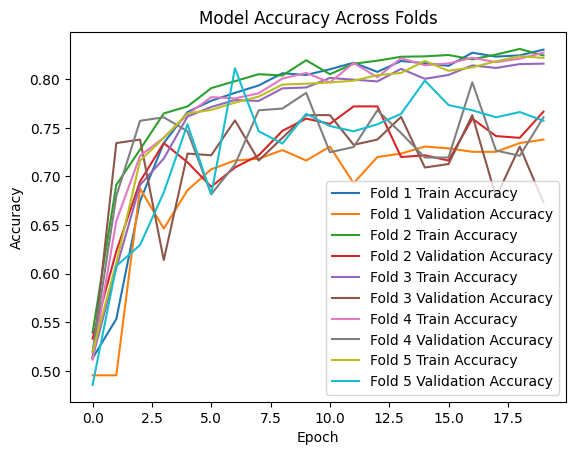

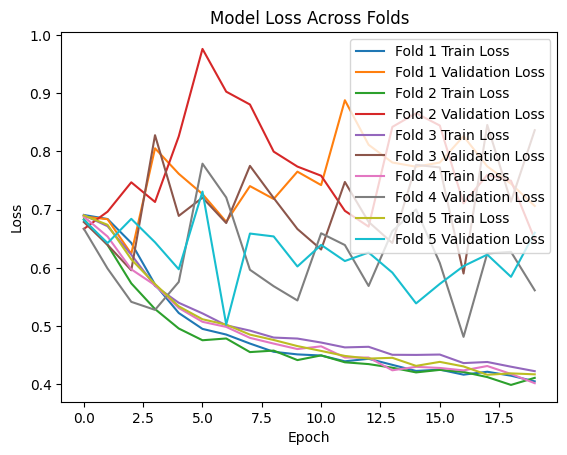

In [114]:
# Define K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Initialize lists to store metrics
f1_scores = []
histories = []

# Perform K-Fold Cross-Validation
fold = 1
for train_index, val_index in kf.split(X_labeled):
    print(f"Training on Fold {fold}...")
    
    # Split the data into training and validation sets
    X_train, X_val = X_train_combined[train_index], X_train_combined[val_index]
    y_train, y_val = Y_train_combined[train_index], Y_train_combined[val_index]  # Fix here
    
    # Flatten the training data for RandomOverSampling
    X_train_flattened = X_train.reshape((X_train.shape[0], -1))
    
    # Apply RandomOverSampling to balance the training data
    ros = RandomOverSampler(sampling_strategy='minority', random_state=42)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train_flattened, y_train)
    
    # Reshape the resampled data back to image shape
    X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 48, 48, 1))
    
    # Shuffle the resampled training data
    X_train_resampled, y_train_resampled = shuffle(X_train_resampled, y_train_resampled, random_state=42)
    
    # Create a new CNN model for each fold
    model = create_model()

    # Train the model with data augmentation
    history = model.fit(
        datagen.flow(X_train_resampled, y_train_resampled, batch_size=32), #if data augmentation is before data split
        validation_data=(X_val.reshape(X_val.shape[0], 48, 48, 1), y_val),  # Ensure X_val has shape (48, 48, 1)
        epochs=20
    )
    
    # Append the training history for later analysis
    histories.append(history.history)
    
    # Evaluate the model
    val_preds = model.predict(X_val.reshape(X_val.shape[0], 48, 48, 1))
    val_preds = np.round(val_preds)  # Convert probabilities to binary 0 or 1

    # Calculate and store the F1 score
    f1 = f1_score(y_val, val_preds)
    f1_scores.append(f1)

    print(f"F1 Score for Fold {fold}: {f1}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_val, val_preds)
    print(f"Confusion Matrix for Fold {fold}:\n", conf_matrix)

    # Increment fold number
    fold += 1

# Print average F1 score
print(f"\nAverage F1 Score: {np.mean(f1_scores)}")

# Plot accuracy and loss curves
for i, history in enumerate(histories):
    plt.plot(history['accuracy'], label=f'Fold {i+1} Train Accuracy')
    plt.plot(history['val_accuracy'], label=f'Fold {i+1} Validation Accuracy')
plt.title('Model Accuracy Across Folds')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

for i, history in enumerate(histories):
    plt.plot(history['loss'], label=f'Fold {i+1} Train Loss')
    plt.plot(history['val_loss'], label=f'Fold {i+1} Validation Loss')
plt.title('Model Loss Across Folds')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

Using CV and the new training set (labeled +  labeled through self-learning)

In [ ]:
# Define K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Initialize lists to store metrics
f1_scores = []
histories = []

# Perform K-Fold Cross-Validation
fold = 1
for train_index, val_index in kf.split(X_combined):
    print(f"Training on Fold {fold}...")
    
    # Split the data into training and validation sets
    X_train, X_val = X_combined[train_index], X_combined[val_index]
    y_train, y_val = y_combined[train_index], y_combined[val_index]
    
    # Flatten the training data for RandomOverSampling
    X_train_flattened = X_train.reshape((X_train.shape[0], -1))
    
    # Apply RandomOverSampling to balance the training data
    ros = RandomOverSampler(sampling_strategy='minority', random_state=42)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train_flattened, y_train)
    
    # Reshape the resampled data back to image shape
    X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 48, 48, 1))
    
    # Shuffle the resampled training data
    X_train_resampled, y_train_resampled = shuffle(X_train_resampled, y_train_resampled, random_state=42)
    
    # Create a new CNN model for each fold
    model = create_model()

    # Train the model with data augmentation
    history = model.fit(
        datagen.flow(X_train_resampled, y_train_resampled, batch_size=32), #if data augmentation is before data split
        validation_data=(X_val.reshape(X_val.shape[0], 48, 48, 1), y_val),  # Ensure X_val has shape (48, 48, 1)
        epochs=20
    )
    
    # Append the training history for later analysis
    histories.append(history.history)
    
    # Evaluate the model
    val_preds = model.predict(X_val.reshape(X_val.shape[0], 48, 48, 1))
    val_preds = np.round(val_preds)  # Convert probabilities to binary 0 or 1

    # Calculate and store the F1 score
    f1 = f1_score(y_val, val_preds)
    f1_scores.append(f1)

    print(f"F1 Score for Fold {fold}: {f1}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_val, val_preds)
    print(f"Confusion Matrix for Fold {fold}:\n", conf_matrix)

    # Increment fold number
    fold += 1

# Print average F1 score
print(f"\nAverage F1 Score: {np.mean(f1_scores)}")

# Plot accuracy and loss curves
for i, history in enumerate(histories):
    plt.plot(history['accuracy'], label=f'Fold {i+1} Train Accuracy')
    plt.plot(history['val_accuracy'], label=f'Fold {i+1} Validation Accuracy')
plt.title('Model Accuracy Across Folds')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

for i, history in enumerate(histories):
    plt.plot(history['loss'], label=f'Fold {i+1} Train Loss')
    plt.plot(history['val_loss'], label=f'Fold {i+1} Validation Loss')
plt.title('Model Loss Across Folds')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

Using a CNN for feature extraction and training the model with a DNN

In [ ]:
# Load the data (replace with actual loading code)
X = np.load('Xtrain1.npy')  
y = np.load('Ytrain1.npy')  

# Preprocessing: Normalize images (pixel values between 0 and 1)
X = X / 255.0

# Reshape the data to add channel dimension (grayscale images)
X = X.reshape(X.shape[0], 48, 48, 1)

# Define K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Initialize lists to store metrics
f1_scores = []
histories = []

# Data augmentation using ImageDataGenerator for CNN training
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2]
)

# Build the CNN feature extractor model
def create_cnn_feature_extractor():
    inputs = Input(shape=(48, 48, 1))
    
    # Convolutional Layer 1
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Convolutional Layer 2
    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Convolutional Layer 3
    x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Flattening
    x = Flatten()(x)

    return Model(inputs, x)

# Build the DNN model
def create_dnn(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(128, activation='relu')(inputs)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)  # Binary classification
    
    return Model(inputs, outputs)

# Perform K-Fold Cross-Validation
fold = 1
for train_index, val_index in kf.split(X):
    print(f"Training on Fold {fold}...")
    
    # Split the data into training and validation sets
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # Flatten the training data for RandomOverSampling
    X_train_flattened = X_train.reshape((X_train.shape[0], -1))
    
    # Apply RandomOverSampling to balance the training data
    ros = RandomOverSampler(sampling_strategy='minority', random_state=42)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train_flattened, y_train)
    
    # Reshape the resampled data back to image shape
    X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 48, 48, 1))
    
    # Shuffle the resampled training data
    X_train_resampled, y_train_resampled = shuffle(X_train_resampled, y_train_resampled, random_state=42)
    
    # Create CNN feature extractor
    cnn_feature_extractor = create_cnn_feature_extractor()
    cnn_features_train = cnn_feature_extractor.predict(X_train_resampled)
    cnn_features_val = cnn_feature_extractor.predict(X_val.reshape(X_val.shape[0], 48, 48, 1))
    
    # Ensure that the features are flattened before feeding to DNN
    cnn_features_train = cnn_features_train.reshape((cnn_features_train.shape[0], -1))  # Flatten the features
    cnn_features_val = cnn_features_val.reshape((cnn_features_val.shape[0], -1))  # Flatten the features
    
    # Create the DNN model
    dnn_model = create_dnn(cnn_features_train.shape[1:])
    
    # Compile the DNN model
    dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the DNN model without data augmentation
    history = dnn_model.fit(
        cnn_features_train, y_train_resampled,
        validation_data=(cnn_features_val, y_val),
        epochs=30,
        batch_size=32
    )
    
    # Append the training history for later analysis
    histories.append(history.history)
    
    # Evaluate the DNN model
    val_preds = dnn_model.predict(cnn_features_val)
    val_preds = np.round(val_preds)  # Convert probabilities to binary 0 or 1

    # Calculate and store the F1 score
    f1 = f1_score(y_val, val_preds)
    f1_scores.append(f1)

    print(f"F1 Score for Fold {fold}: {f1}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_val, val_preds)
    print(f"Confusion Matrix for Fold {fold}:\n", conf_matrix)

    # Increment fold number
    fold += 1

# Print average F1 score
print(f"\nAverage F1 Score: {np.mean(f1_scores)}")

# Plot accuracy and loss curves
for i, history in enumerate(histories):
    plt.plot(history['accuracy'], label=f'Fold {i+1} Train Accuracy')
    plt.plot(history['val_accuracy'], label=f'Fold {i+1} Validation Accuracy')
plt.title('Model Accuracy Across Folds')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

for i, history in enumerate(histories):
    plt.plot(history['loss'], label=f'Fold {i+1} Train Loss')
    plt.plot(history['val_loss'], label=f'Fold {i+1} Validation Loss')
plt.title('Model Loss Across Folds')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


In [ ]:
# Load the data (replace with actual loading code)
X = X_combined
y = y_combined

# Define K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Initialize lists to store metrics
f1_scores = []
histories = []

# Data augmentation using ImageDataGenerator for CNN training
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2]
)

# Build the CNN feature extractor model
def create_cnn_feature_extractor():
    inputs = Input(shape=(48, 48, 1))
    
    # Convolutional Layer 1
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Convolutional Layer 2
    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Convolutional Layer 3
    x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Flattening
    x = Flatten()(x)

    return Model(inputs, x)

# Build the DNN model
def create_dnn(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(128, activation='relu')(inputs)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)  # Binary classification
    
    return Model(inputs, outputs)

# Perform K-Fold Cross-Validation
fold = 1
for train_index, val_index in kf.split(X):
    print(f"Training on Fold {fold}...")
    
    # Split the data into training and validation sets
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # Flatten the training data for RandomOverSampling
    X_train_flattened = X_train.reshape((X_train.shape[0], -1))
    
    # Apply RandomOverSampling to balance the training data
    ros = RandomOverSampler(sampling_strategy='minority', random_state=42)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train_flattened, y_train)
    
    # Reshape the resampled data back to image shape
    X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 48, 48, 1))
    
    # Shuffle the resampled training data
    X_train_resampled, y_train_resampled = shuffle(X_train_resampled, y_train_resampled, random_state=42)
    
    # Create CNN feature extractor
    cnn_feature_extractor = create_cnn_feature_extractor()
    cnn_features_train = cnn_feature_extractor.predict(X_train_resampled)
    cnn_features_val = cnn_feature_extractor.predict(X_val.reshape(X_val.shape[0], 48, 48, 1))
    
    # Ensure that the features are flattened before feeding to DNN
    cnn_features_train = cnn_features_train.reshape((cnn_features_train.shape[0], -1))  # Flatten the features
    cnn_features_val = cnn_features_val.reshape((cnn_features_val.shape[0], -1))  # Flatten the features
    
    # Create the DNN model
    dnn_model = create_dnn(cnn_features_train.shape[1:])
    
    # Compile the DNN model
    dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the DNN model without data augmentation
    history = dnn_model.fit(
        cnn_features_train, y_train_resampled,
        validation_data=(cnn_features_val, y_val),
        epochs=30,
        batch_size=32
    )
    
    # Append the training history for later analysis
    histories.append(history.history)
    
    # Evaluate the DNN model
    val_preds = dnn_model.predict(cnn_features_val)
    val_preds = np.round(val_preds)  # Convert probabilities to binary 0 or 1

    # Calculate and store the F1 score
    f1 = f1_score(y_val, val_preds)
    f1_scores.append(f1)

    print(f"F1 Score for Fold {fold}: {f1}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_val, val_preds)
    print(f"Confusion Matrix for Fold {fold}:\n", conf_matrix)

    # Increment fold number
    fold += 1

# Print average F1 score
print(f"\nAverage F1 Score: {np.mean(f1_scores)}")

# Plot accuracy and loss curves
for i, history in enumerate(histories):
    plt.plot(history['accuracy'], label=f'Fold {i+1} Train Accuracy')
    plt.plot(history['val_accuracy'], label=f'Fold {i+1} Validation Accuracy')
plt.title('Model Accuracy Across Folds')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

for i, history in enumerate(histories):
    plt.plot(history['loss'], label=f'Fold {i+1} Train Loss')
    plt.plot(history['val_loss'], label=f'Fold {i+1} Validation Loss')
plt.title('Model Loss Across Folds')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


SVM for pseudo-labeling

In [120]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score
import numpy as np

# Step 1: Normalize the labeled data for One-Class SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined.reshape(X_train_combined.shape[0], -1))

# Step 2: Train the One-Class SVM on the labeled data
# nu is the parameter that controls the proportion of outliers (default is 0.5)
one_class_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.1)
one_class_svm.fit(X_train_scaled)

# Step 3: Normalize the unlabeled data using the same scaler
X_unlabeled_scaled = scaler.transform(X_unlabeled.reshape(X_unlabeled.shape[0], -1))

# Step 4: Use One-Class SVM to predict pseudo-labels for the unlabeled data
# Predict output for the unlabeled data; 1 means it belongs to the class, -1 means it's an outlier
pseudo_labels = one_class_svm.predict(X_unlabeled_scaled)

# Convert -1 (outliers) to 0, as we assume they don't belong to the same class
pseudo_labels = np.where(pseudo_labels == -1, 0, 1)

# Step 5: Combine labeled data with the pseudo-labeled data
X_combined = np.concatenate((X_train_scaled, X_unlabeled_scaled), axis=0)
y_combined = np.concatenate((Y_train_combined, pseudo_labels), axis=0)

# Step 6: Retrain the model (e.g., a regular classifier like SVM, logistic regression, etc.) using the combined dataset
from sklearn.svm import SVC

svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_combined, y_combined)

# Step 7: Evaluate the model on the validation set
# Normalize the validation set
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
val_preds = svm_classifier.predict(X_val_reshaped)

# Step 8: Print evaluation results
print(classification_report(y_val, val_preds))
f1 = f1_score(y_val, val_preds)
print("F1 Score: ", f1)


              precision    recall  f1-score   support

         0.0       1.00      0.00      0.01       297
         1.0       0.47      1.00      0.64       259

    accuracy                           0.47       556
   macro avg       0.73      0.50      0.32       556
weighted avg       0.75      0.47      0.30       556

F1 Score:  0.6363636363636364
